In [1]:
import glob
import os
import sys
import time as time_module


import numpy as np
import pandas as pd
from mvgavg import mvgavg
import skimage
import importlib
import matplotlib.pyplot as plt
%matplotlib widget

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tools

PAMFluo_path = "C:/Users/Lab/Desktop/DREAM_repo/Codes_Alienor/PAMFluo-dynamic_python"
if PAMFluo_path not in sys.path:
    sys.path.append(PAMFluo_path)

import VoltageIntensityClass


In [2]:
######## Set the path to experimental and processed data ########

path = "E:/Experimental_data/DREAM_microscope/"
exp = "2023-10-24_18_05_Activation_curve/"
folder = path + exp
data_processing_folder = folder + "data_processing/"
if not os.path.exists(data_processing_folder):
    os.mkdir(data_processing_folder)


In [3]:
######## Load photodiode outputs ########

list_photodiode_output = glob.glob(folder + "*output*")

outputs_photodiode = []
for i in list_photodiode_output:
    outputs_photodiode.append(pd.read_csv(i))

In [4]:
# Subtract baseline from photodiode outputs

for i, output in enumerate(outputs_photodiode):
    output["Fluo"] = output["Fluo"] - np.mean(output["Fluo"][0:tools.closest_index(output["time"], 4.9)])

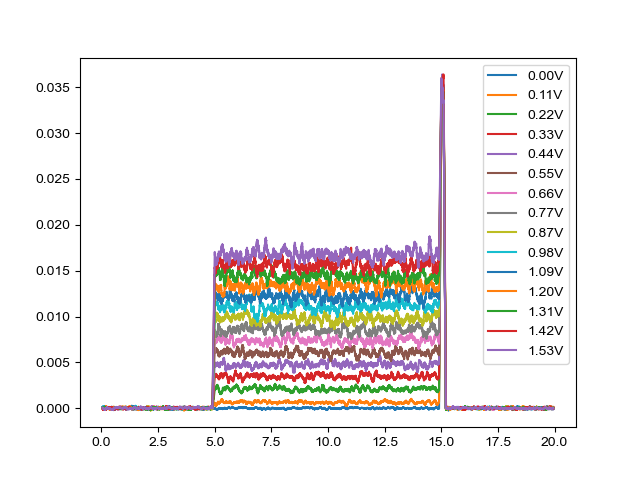

In [32]:
# Plot photodiode outputs

# "time" : time in seconds
# "Intensity" : measured intensity in V
# "Fluo" : intensity measured by the MPPC/only noise if mirror is closed
# "Blue" : set intensity for blue LED in V
# "Purple" : set intensity for purple LED in V
# "Green" : set intensity for green LED in V
# "Trigger" : trigger signal for the camera
# "jspq" : unknown

avg = 100
fig, ax = plt.subplots()
for i, output in enumerate(outputs_photodiode):
    x = mvgavg(output["time"], avg)
    y = mvgavg(output["Intensity"], avg)
    #y2 = mvgavg(output["Blue"], avg)
    ax.plot(x, y, '-', label= list_photodiode_output[i].split("\\")[-1].split("_")[-1].split(".csv")[0], color = f"C{i}")
    #ax.plot(x, y2, color = f"C{i}")

ax.legend()


In [6]:
######## Get the measured intensities ########

Actinic_measured_volt = []
Sat_measured_volt = []

for i in range(len(outputs_photodiode)):
    Actinic_measured_volt.append(np.mean(outputs_photodiode[i][tools.closest_index(outputs_photodiode[i]["time"], 5.1):tools.closest_index(outputs_photodiode[i]["time"], 14)]["Intensity"])*100)
    Sat_measured_volt.append(np.mean(outputs_photodiode[i][tools.closest_index(outputs_photodiode[i]["time"], 14.975):tools.closest_index(outputs_photodiode[i]["time"], 15.147)]["Intensity"])*100)
    
Sat_set_volt = 3.4
Actinic_set_volt = np.linspace(0, 0.45*Sat_set_volt, 15)


In [7]:
######## Load videos ########

loading_time = time_module.time()

video_times = []
videos = []

for file in sorted(glob.glob(folder + "*video_timing*"), key=os.path.getmtime):
    video_times.append(np.load(file))

for file in sorted(glob.glob(folder + "*video.tiff"), key=os.path.getmtime):
    videos.append(skimage.io.imread(file)[:,400:500, 400:500])

videos = np.asarray(videos)    

N = videos.shape[0] # number of videos
T = videos.shape[1] # number of frames
H = videos.shape[2] # height if image in pixels
W = videos.shape[3] # width of image in pixels


loading_time = time_module.time() - loading_time
print("Loading time = " + str(loading_time) + "s")


Loading time = 15.35950779914856s


In [8]:
######### Create sample video ########
if False:
    sample_video = videos.mean(axis=0)
    skimage.io.imsave(data_processing_folder + "sample_video_marcelo.tiff", sample_video)

sample_video = skimage.io.imread(data_processing_folder + "sample_video_marcelo.tiff")

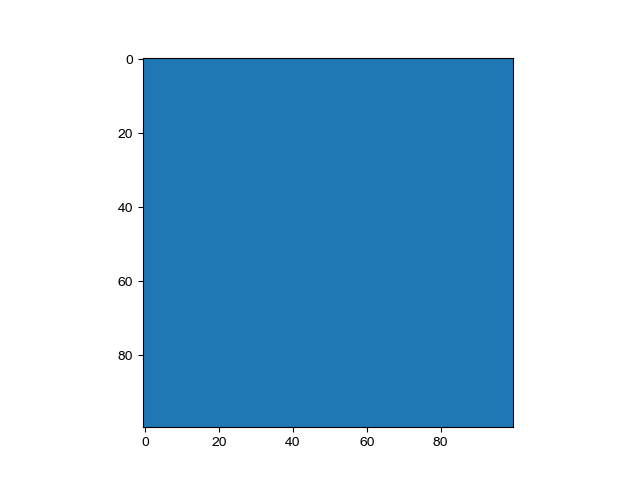

In [9]:
######### Perform segmentation based on sample video ########

if False:
    import seg_func
    importlib.reload(seg_func)

    segmentation_time = time_module.time()
    mask, FO = seg_func.im_seg(sample_video)
    mask = mask==mask
    np.save(data_processing_folder + "/mask.npy", mask)

    segmentation_time = time_module.time() - segmentation_time
    print("Segmentation time = " + str(segmentation_time) + "s")

mask = np.load(data_processing_folder + "/mask.npy")
plt.figure(); plt.imshow(mask, cmap='tab20')


In [12]:
######### Use mask to compute single cell dynamics ########

if True:
    frame_rate = 15 # frame rate of the camera in Hz
   
    from tqdm import tqdm

    nb_cell = np.max(mask.astype(int))

    Cell = np.zeros([nb_cell,N,T])
    Cell_std = np.zeros([nb_cell,N,T])

    for k in tqdm(range(nb_cell)):
        Intensity = np.zeros([N,T])
        Intensity_std = np.zeros([N,T])
        for i in range(N):
            fluo = np.zeros(T)
            fluo_std =  np.zeros(T)
            for j in range(T):        
                fluo[j] = np.mean(videos[i][j][mask])
                fluo_std[j] = np.std(videos[i][j][mask])
                print(np.mean(videos[i][j][mask]))
            Intensity[i][:] = fluo - np.mean(fluo[0:int(frame_rate*4.9)])
            Intensity_std[i][:] = fluo_std
        Cell[k][:][:] = Intensity
        Cell_std[k][:][:] = Intensity_std
    
    np.save(data_processing_folder + "/Single_cell_dynamics.npy", Cell)
    np.save(data_processing_folder + "/Single_cell_dynamics_std.npy", Cell_std)

Cell = np.load(data_processing_folder + "/Single_cell_dynamics.npy")
Cell_std = np.load(data_processing_folder + "/Single_cell_dynamics_std.npy")


  0%|          | 0/1 [00:00<?, ?it/s]

0.1104
0.1258
0.1311
0.1164
0.1125
0.1353
0.1404
0.1183
0.1228
0.1299
0.1247
0.1274
0.1296
0.1304
0.1128
0.1314
0.1254
0.1388
0.1337
0.135
0.1249
0.1384
0.1461
0.1154
0.1289
0.1286
0.1321
0.1247
0.1318
0.1303
0.1365
0.1184
0.1373
0.1326
0.1167
0.1207
0.1347
0.1287
0.1253
0.1518
0.1292
0.1251
0.1455
0.1264
0.1381
0.1283
0.1239
0.1319
0.1218
0.1344
0.1161
0.1359
0.1251
0.1356
0.1157
0.1309
0.1357
0.123
0.1197
0.1201
0.1229
0.1403
0.1348
0.1261
0.122
0.1207
0.1237
0.1295
0.1435
0.1217
0.1105
0.1251
0.1378
0.1396
0.1306
0.1204
0.1225
0.123
0.129
0.1263
0.1178
0.1388
0.1197
0.1367
0.1155
0.1303
0.1201
0.1162
0.1334
0.1309
0.1192
0.1316
0.126
0.1284
0.1473
0.1278
0.1232
0.1211
0.1222
0.1326
0.1229
0.1326
0.1286
0.1387
0.127
0.1382
0.1275
0.1172
0.1303
0.1224
0.12
0.1369
0.1274
0.1257
0.129
0.1264
0.1286
0.1392
0.1455
0.1239
0.1268
0.1349
0.1403
0.1278
0.1308
0.1255
0.1378
0.1197
0.1312
0.1334
0.1196
0.1397
0.1393
0.1247
0.123
0.1289
0.1363
0.123
0.1196
0.1249
0.1322
0.1307
0.1161
0.1277
0.12

100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

46.8
46.765
46.7478
46.7877
46.7779
46.8145
46.8061
46.7452
46.8036
46.8014
46.7803
46.8181
46.7878
46.7802
46.8144
46.8141
46.7723
46.7749
46.7626
46.7935
46.7688
46.7572
46.7609
46.7493
46.7877
46.7939
46.7806
46.8091
46.7531
46.7782
46.7684
46.8033
46.8007
46.7623
46.7838
46.7717
46.7894
46.7565
46.7526
46.7715
46.7823
46.7823
46.8013
46.7645
46.761
46.7698
46.78
46.7741
46.771
46.7526
46.7156
46.7639
46.7604
46.7555
46.7495
46.7573
46.8002
46.7183
46.7403
46.8031
46.736
46.7555
46.7631
46.6758
46.7414
46.7414
46.7358
46.7745
46.7436
46.7489
46.749
46.7673
46.759
46.7646
46.7605
46.7105
46.7555
46.7338
46.7824
46.7533
46.7419
46.7554
46.749
46.7225
46.7235
46.7159
46.7148
47.0022
103.295
102.8419
102.2352
0.1289
0.1258
0.13
0.14
0.144
0.1266
0.1427
0.1274
0.1262
0.1227
0.1354
0.1278
0.1393
0.1278
0.1211
0.1347
0.1321
0.1331
0.1278
0.1418
0.1385
0.1423
0.1303
0.1215
0.1501
0.1349
0.1269
0.1292
0.1333
0.1338
0.126
0.1502
0.1301
0.1262
0.1272
0.1306
0.1299
0.1278
0.1403
0.1338
0.1283
0

In [13]:
Cell.shape

(1, 15, 300)

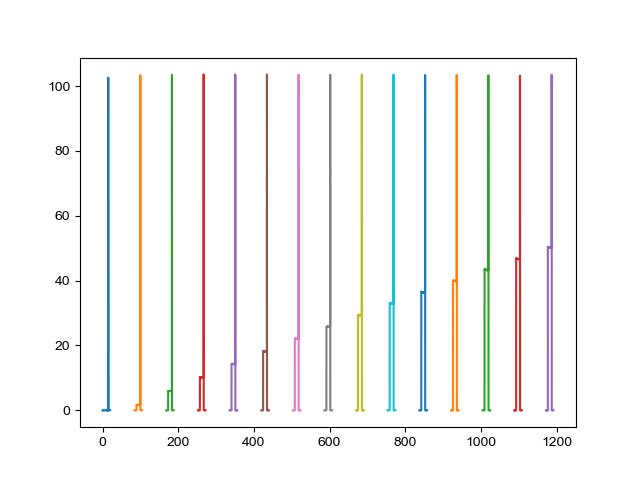

In [15]:
######### Plot single cell dynamics ########

nb_cell = len(Cell)
nb_video = len(Cell[0])
frames = len(Cell[0][0])

avg = 1
fig = plt.figure()
ax = plt.gca()
for i in range(nb_video):
        x = mvgavg(video_times[i] - video_times[0][0], avg)
        y = mvgavg(Cell[0][i], avg)
        ax.plot(x,y, label = "Cell " + str(j+1))

In [16]:
sum_cell = np.zeros_like(Cell[0])
for i in range(len(Cell)):
    sum_cell += Cell[i]


In [17]:
data_dict = {}
data_dict["time"] = video_times[0] - video_times[0][0]
for i in range(len(sum_cell)):
    data_dict[f"{Actinic_set_volt[i]:.2f}V"] = sum_cell[i]

data_df = pd.DataFrame(data_dict)
data_df

,time,0.00V,0.11V,0.22V,0.33V,0.44V,0.55V,0.66V,0.77V,0.87V,0.98V,1.09V,1.20V,1.31V,1.42V,1.53V
0,0.000000,-0.017778,-0.014564,-0.023034,-0.009525,-0.009159,-0.005482,-0.016385,-0.009596,-0.00739,-0.004904,-0.013804,-0.011456,-0.006527,-0.014127,-0.008871
1,0.046398,-0.002378,-0.007264,-0.003334,-0.011325,-0.005159,0.004018,-0.010385,0.006904,0.01231,0.003696,-0.002604,-0.005056,-0.000927,0.003673,-0.006071
2,0.107748,0.002922,0.002336,-0.014234,-0.006625,-0.004059,-0.004982,0.008415,-0.012296,-0.00269,-0.029304,0.000296,-0.003956,0.000773,0.005273,0.000529
3,0.185416,-0.011778,0.012036,0.009466,-0.008525,-0.003359,0.000618,0.000115,-0.000796,0.00471,-0.002104,-0.003504,-0.001156,0.007273,-0.000227,0.001029
4,0.247670,-0.015678,-0.003364,-0.000234,0.008975,0.003841,0.003418,0.006415,0.000204,-0.00989,-0.011304,-0.010104,0.020244,-0.006027,-0.009227,-0.014271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,19.651639,0.006522,0.004936,0.007166,0.022975,0.002841,0.006418,0.004115,0.014104,0.01651,0.017596,-0.002304,0.024244,0.018173,0.009273,0.013029
296,19.714597,0.001822,0.005136,0.001866,0.002175,0.009341,0.005518,0.016215,-0.000296,0.01391,0.014696,0.001396,0.031644,0.009373,0.001773,0.011429
297,19.777342,0.006822,0.014636,0.018866,0.002375,0.009141,0.007918,-0.000185,-0.013196,0.00111,0.008496,0.007496,0.007544,0.009873,0.007873,-0.000671
298,19.839529,-0.003378,0.003436,0.002466,0.007975,0.001841,0.003018,0.006215,0.015304,0.01931,0.007996,0.010696,0.027344,0.018773,0.014773,-0.000371


In [18]:
importlib.reload(VoltageIntensityClass)

a480 = 82
a532=7.7

V = VoltageIntensityClass.VoltageIntensity(folder = "E:/Experimental_data/DREAM_microscope/2023-10-18_16_53_bode_diagram")
I = V.get_intensity_voltage("blue", 1, np.array(Actinic_measured_volt))*1e6*a480/a532
I_sat = V.get_intensity_voltage("blue", 1, np.array(Sat_measured_volt))*1e6*a480/a532

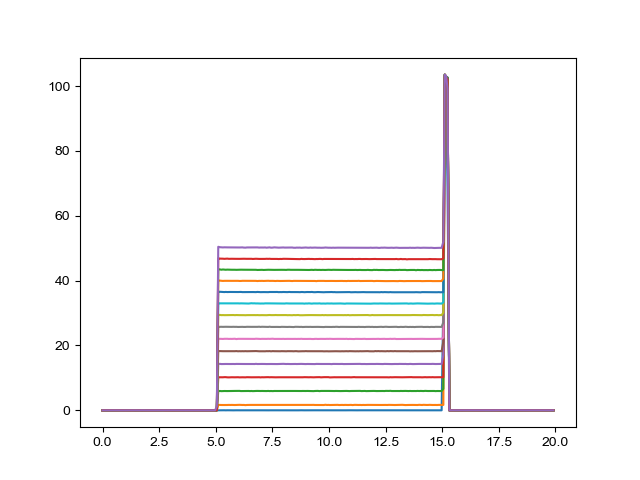

In [50]:
fig, ax =  plt.subplots()
x = data_df.time
for i, k in enumerate(data_df.columns[1:]):
    y = data_df[k].copy()
    ax.plot(x,y, '-')



Text(0, 0.5, 'Actinic voltage measured (V)')

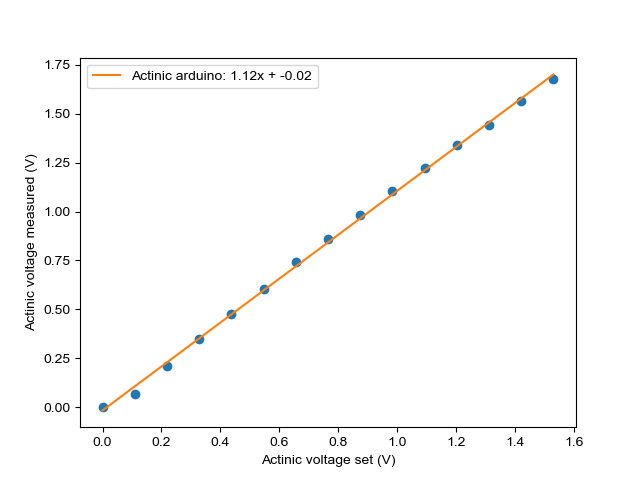

In [49]:
fig, ax = plt.subplots()
popt, xfit, yfit = tools.lin_fit(Actinic_set_volt, Actinic_measured_volt, Actinic_set_volt[0], Actinic_set_volt[-1], 100)
ax.plot(Actinic_set_volt, Actinic_measured_volt, 'o')
ax.plot(xfit, yfit, label = f"Actinic arduino: {popt[0]:.2f}x + {popt[1]:.2f}")
ax.legend()
ax.set_xlabel("Actinic voltage set (V)")
ax.set_ylabel("Actinic voltage measured (V)")

In [21]:
def compute_params(Data_df):

    F_max = []
    F_stat = []
    
    for i, k in enumerate(Data_df.columns[1:]):
        F_max.append(Data_df[k][tools.closest_index(Data_df.time,15.2)])
        F_stat.append(np.mean(Data_df[k][tools.closest_index(Data_df.time, 10):tools.closest_index(Data_df.time, 14.9)]))
        
    params_dic = {'Actinic': I, 'F_max': F_max, 'F_stat': F_stat}
    
    return params_dic

In [51]:
params_df = compute_params(data_df)


Text(0, 0.5, 'Fluorescence (a.u.)')

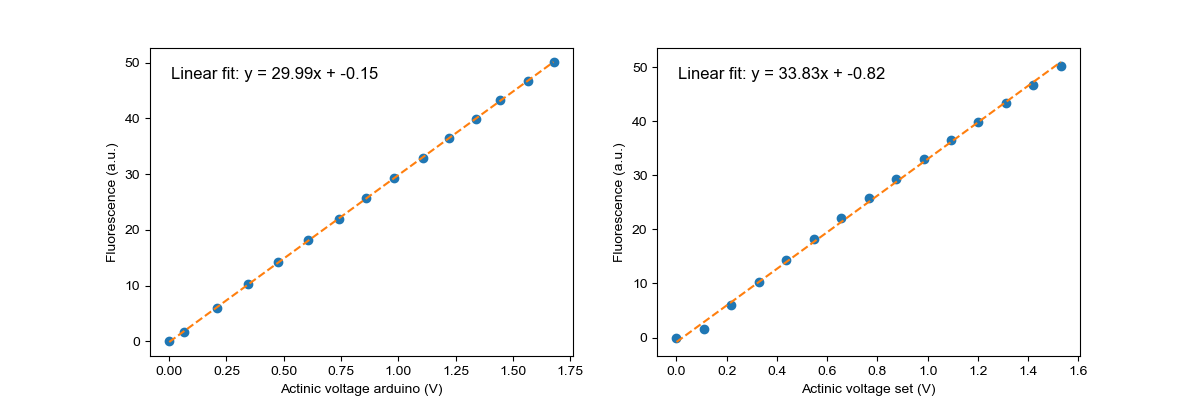

In [48]:
fig, ax = plt.subplots(1,2, figsize = (12,4))
ax[0].plot(Actinic_measured_volt, params_df["F_stat"], 'o', label = "Fstat")
popt, xfit, yfit = tools.lin_fit(Actinic_measured_volt[1:], params_df["F_stat"][1:], Actinic_measured_volt[0], Actinic_measured_volt[-1], 100)
ax[0].plot(xfit, yfit, "--")
ax[0].text(0.05, 0.9, f"Linear fit: y = {popt[0]:.2f}x + {popt[1]:.2f}", transform=ax[0].transAxes, fontsize=12)
ax[0].set_xlabel("Actinic voltage arduino (V)")
ax[0].set_ylabel("Fluorescence (a.u.)")

ax[1].plot(Actinic_set_volt, params_df["F_stat"], 'o', label = "Fstat")
popt, xfit, yfit = tools.lin_fit(Actinic_set_volt[1:], params_df["F_stat"][1:], Actinic_set_volt[0], Actinic_set_volt[-1], 100)
ax[1].plot(xfit, yfit, "--")
ax[1].text(0.05, 0.9, f"Linear fit: y = {popt[0]:.2f}x + {popt[1]:.2f}", transform=ax[1].transAxes, fontsize=12) 
ax[1].set_xlabel("Actinic voltage set (V)")
ax[1].set_ylabel("Fluorescence (a.u.)")